# Ensemble Learning

## Initial Imports

In [200]:
import warnings
warnings.filterwarnings('ignore')

In [201]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import calendar

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [223]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [224]:
# Binary encoding on the data on in text
df = pd.get_dummies(df, columns=["home_ownership", "verification_status", "pymnt_plan",
                                 "initial_list_status", "application_type", "hardship_flag", 
                                 "debt_settlement_flag"])
df.head()

,loan_amnt,int_rate,installment,annual_inc,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,Mar-2019,low_risk,27.24,0.0,0.0,8.0,...,0,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,Mar-2019,low_risk,20.23,0.0,0.0,17.0,...,0,0,1,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,Mar-2019,low_risk,24.26,0.0,0.0,8.0,...,0,0,1,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,Mar-2019,low_risk,31.44,0.0,1.0,10.0,...,0,0,1,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,Mar-2019,low_risk,18.76,0.0,1.0,14.0,...,1,0,0,1,0,1,1,0,1,1


In [225]:
#Splitting Month and year in columns - issue_d and next_pymnt_d
df['year_issue'] = pd.DatetimeIndex(df['issue_d']).year
df['month_issue'] = pd.DatetimeIndex(df['issue_d']).month
df['year_next_pymnt_d'] = pd.DatetimeIndex(df['next_pymnt_d']).year
df['month_next_pymnt_d'] = pd.DatetimeIndex(df['next_pymnt_d']).month
df = df.drop(["issue_d","next_pymnt_d"], axis = 1)
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N,year_issue,month_issue,year_next_pymnt_d,month_next_pymnt_d
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,0,1,1,0,1,1,2019,3,2019,5
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,0,1,1,0,1,1,2019,3,2019,5
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,0,1,1,0,1,1,2019,3,2019,5
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,0,1,1,0,1,1,2019,3,2019,5
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,0,1,1,0,1,1,2019,3,2019,5


## Split the Data into Training and Testing

In [226]:
# Create our features
X = df.drop(columns='loan_status')

# Create our target
y = df['loan_status']

In [227]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N,year_issue,month_issue,year_next_pymnt_d,month_next_pymnt_d
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.0,68817.000000,68817.0,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.123879,0.876121,0.860340,0.139660,1.0,1.0,2019.0,1.726172,2019.0,4.616839
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.329446,0.329446,0.346637,0.346637,0.0,0.0,0.0,0.743862,0.0,0.486161
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,1.0,2019.0,1.000000,2019.0,4.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,1.0,2019.0,1.000000,2019.0,4.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,1.0,2019.0,2.000000,2019.0,5.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,1.0,2019.0,2.000000,2019.0,5.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2019.0,3.000000,2019.0,5.000000


In [228]:
# Check the balance of our target values
Counter(y)

Counter({'low_risk': 68470, 'high_risk': 347})

In [229]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [230]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [211]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [212]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [213]:
# Resample the training data with the BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf_model = brf_model.fit(X_train_scaled, y_train)
predictions_brf = brf_model.predict(X_test_scaled)

In [214]:
# Calculated the balanced accuracy score
acc_score_brf = balanced_accuracy_score(y_test, predictions_brf)

In [215]:
# Display the confusion matrix
cm_brf = confusion_matrix(y_test, predictions_brf)
cm_brf_df = pd.DataFrame(cm_brf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
# Displaying results
print("Confusion Matrix")
display(cm_brf_df)
print(f"Accuracy Score : {acc_score_brf}")

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,67,34
Actual 1,2457,14647


Accuracy Score : 0.7598578642943807


In [216]:
# Print the imbalanced classification report
print("Classification Report")
print(classification_report_imbalanced(y_test, predictions_brf))

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.66      0.86      0.05      0.75      0.56       101
   low_risk       1.00      0.86      0.66      0.92      0.75      0.58     17104

avg / total       0.99      0.86      0.66      0.92      0.75      0.58     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

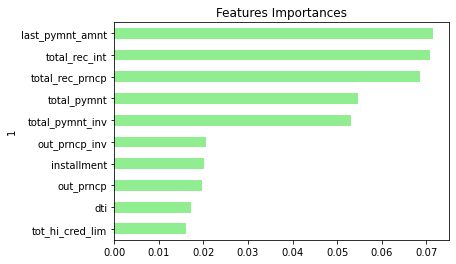

In [217]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
# Printing only top 10 for readability purpose
importances_sorted = importances_df.head(10).sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Easy Ensemble Classifier

In [231]:
# Train the Classifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_model = eec_model.fit(X_train_scaled, y_train)
predictions_eec = eec_model.predict(X_test_scaled)

In [232]:
# Calculated the balanced accuracy score
acc_score_eec = balanced_accuracy_score(y_test, predictions_eec)

In [233]:
# Display the confusion matrix
cm_eec = confusion_matrix(y_test, predictions_eec)
cm_eec_df = pd.DataFrame(cm_eec, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
# Displaying results
print("Confusion Matrix")
display(cm_eec_df)
print(f"Accuracy Score : {acc_score_eec}")

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,93,8
Actual 1,956,16148


Accuracy Score : 0.9324493604645778


In [234]:
# Print the imbalanced classification report
print("Classification Report")
print(classification_report_imbalanced(y_test, predictions_eec))

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Easy Ensemble Classifier has a higher accuracy score at 93% as compared to the Balanced Random Forest Classifier at 76%.

2. Which model had the best recall score?

    Lower recall score being the best, the Balanced Random Forest Classifier Model has the best recall score.

3. Which model had the best geometric mean score?

    The Geometric Mean is the best in the Easy Ensemble Classifier Model.

4. What are the top three features?

    The top 3 features are 'last_pymnt_amt', 'total_rec_int' & 'total_rec_prncp' - in the same order.